In [ ]:
!pip install ipymarkup
!pip install yargy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26099 sha256=a48d43913980523b432d1e5b680e02974a9a9ded1e7dffa4330a2a4857b4e8ac
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 65.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=ced78cf6d89df44e72a5e0c9fbb24f425ed2f776b7b64ad6ee78ffbd5ae161f3
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c973

# Imports

In [ ]:
import pandas as pd
import numpy as np

import json

from ipymarkup import show_span_ascii_markup as show_markup

from yargy import (
    Parser,
    rule, or_, and_, not_
)
from yargy.predicates import (
    eq, in_,
    type, normalized,
    dictionary,
    gte, lte
)
from yargy.pipelines import (
    pipeline,
    morph_pipeline
)
from yargy.interpretation import (
    fact,
    attribute
)
from yargy.tokenizer import MorphTokenizer, EOL

from random import seed, sample

seed(41)

# Препроцессинг датасета

In [ ]:
df_resume = pd.read_csv('/content/df_resume.csv')

In [ ]:
df_resume.resume[3]

'id резюме : 32029550 обновлено 24-04-2023 16:05:59 44 года , мужчина Санкт-Петербург , Автово Гражданство : Россия Желаемая должность и зарплата Прораб дорожное строительство ( благоустройство ) 100 000 руб . График , место работы Полный рабочий день . Ищу работу в городе : Санкт-Петербург . Командировки возможны . Стаж в желаемой должности 5 лет Специализации Архитектура , проектирование , Сметное дело , Снабжение , закупки , тендеры , Геодезия , землеустройство , Инженерные системы , Автодорожное строительство Профессиональные навыки Ведение переговоров , управление персоналом , чтение чертежей , работа с проектно-сметной документацией , строительно-монтажные работы , руководство бригадой , контроль качества выполненных работ , ведение объекта Основное образование Высшее , Ивановский государственный университет , 2019 ОПЫТ РАБОТЫ 2008 , сентябрь — 2018 , сентябрь , 10 лет директор ооо дорпромстрой административно хозяйственная деятельность . 2001 , июнь — 2008 , сентябрь , 7 лет мас

In [ ]:
from yargy.tokenizer import MorphTokenizer, EOL
TOKENIZER = MorphTokenizer().remove_types(EOL)

In [ ]:
def get_tokenized_resume_from_yargy_tokenizer(resume):
    new_resume = ' '
    for i in range(len(list(TOKENIZER(resume)))):
        new_resume += list(TOKENIZER(resume))[i].value + ' '
    return new_resume

In [ ]:
df_resume['resume'] = df_resume['resume'].apply(lambda x: get_tokenized_resume_from_yargy_tokenizer(x))

# Yargy parser

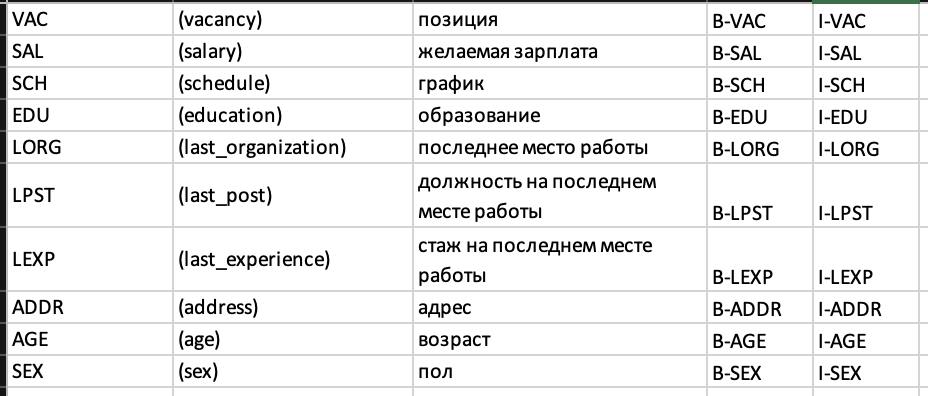

## Utils

In [ ]:
def load_lines(path):
    with open(path) as file:
        for line in file:
            yield line.rstrip('\n')

## Rules

In [ ]:
INT = type('INT')
COMMA = eq(',')
COLON = eq(':')

In [ ]:
def get_labels_from_yargy(text, spans, label):
    if spans[-1] != len(text)-1:
        spans.append(len(text)-1)
    labels_from_yargy = []
    tags_out = True
    for i in range(len(spans)-1):
        if text[spans[i]] != ' ' and tags_out and i!=0:
            try:
                spans[i] += text[spans[i]:spans[i+1]].index(" ")
            except:
                pass
        for word in text[spans[i]:spans[i+1]].split():
            if tags_out:
                labels_from_yargy.append('O')
            else:
                labels_from_yargy.append(label)
        tags_out = not tags_out
    return labels_from_yargy

### SEX

In [ ]:
Intro_gender = fact('Intro', ['gender'])

GENDERS = {
    'женщина': 'female',
    'мужчина': 'male'
}

GENDER = in_(GENDERS).interpretation(
    Intro_gender.gender.custom(GENDERS.get)
)

INTRO_GENDER = rule(GENDER)

In [ ]:
parser = Parser(INTRO_GENDER, tokenizer=TOKENIZER)

labeled_sex_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    if matches:
        match = matches[0]
        start, end = match.span
        labeled_sex_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, [0, start, end], 'SEX'))]

In [ ]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_sex_token_from_yargy, 
                                             orient='index', 
                                             columns=['sex_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)

df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df_resume.merge(df_label_from_yargy, on='id', how='left')

## AGE

In [ ]:
Age = fact(
    'Age',
    ['age']
)

AGE_INT = and_(
    gte(14),
    lte(75)
).interpretation(
    Age.age.custom(int)
)

AGE = rule(
    AGE_INT,
    normalized('год')
)

In [ ]:
parser = Parser(AGE)

labeled_age_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    if matches:
        match = matches[0]
        start, end = match.span
        labeled_age_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, [0, start, end], 'AGE'))]

In [ ]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_age_token_from_yargy, 
                                             orient='index', 
                                             columns=['age_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

## SAL

In [ ]:
Money = fact(
    'Money',
    ['amount', 'currency']
)

CURRENCIES = {
    'рублей': 'RUB',
    'руб': 'RUB',
    'грн': 'GRN',
    'бел рублей': 'BEL',
    'бел руб': 'BEL',
    'RUB': 'RUB',
    'EUR': 'EUR',
    'KZT': 'KZT',
    'USD': 'USD',
    'KGS': 'KGS'
}

CURRENCY = pipeline(CURRENCIES).interpretation(
    Money.currency.normalized().custom(CURRENCIES.get)
)


def normalize_amount(value):
    return int(value.replace(' ', ''))


AMOUNT = or_(
    rule(INT),
    rule(INT, INT),
    rule(INT, "-", INT),
)

MONEY = rule(
    AMOUNT,
    CURRENCY
)

In [ ]:
parser = Parser(MONEY)

labeled_sal_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    if matches:
        match = matches[0]
        start, end = match.span
        labeled_sal_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, [0, start, end], 'SAL'))]

In [ ]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_sal_token_from_yargy, 
                                             orient='index', 
                                             columns=['sal_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

## ADDR

In [ ]:
AREAS = set(load_lines('areas.txt'))

Address = fact(
    'Location',
    ['area', 'metro']
)

AREA = morph_pipeline(AREAS).interpretation(
    Address.area
)

ADDR = or_(
    rule(
      AREA
    ),
).interpretation(
    Address
)

In [ ]:
parser = Parser(ADDR)

labeled_addr_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    spans = [0]
    if matches:
        for i in range(len(matches)):
            match_i = matches[i]
            spans.extend(match_i.span)
        labeled_addr_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, spans, 'ADDR'))]

In [ ]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_addr_token_from_yargy, 
                                             orient='index', 
                                             columns=['addr_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

### VAC

In [ ]:
SPECIALIZATIONS = set(load_lines('specialization.txt'))
SUBSPECIALIZATIONS = set(load_lines('subspecialization.txt'))


SPECIALIZATION = pipeline(SPECIALIZATIONS)
SUBSPECIALIZATION = pipeline(SUBSPECIALIZATIONS)

POSITION = rule(
    or_(
        SPECIALIZATION,
        SUBSPECIALIZATION
    )
)

In [ ]:
parser = Parser(POSITION, tokenizer=TOKENIZER)

labeled_vac_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    spans = [0]
    if matches:
        for i in range(len(matches)):
            match_i = matches[i]
            spans.extend(match_i.span)
        labeled_vac_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, spans, 'VAC'))]

In [ ]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_vac_token_from_yargy, 
                                             orient='index', 
                                             columns=['vac_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

### SCH

In [ ]:
Intro_sch = fact('Intro', ['schedule'])

TYPES = {
    'полный день': 'full',
    'полный рабочий день': 'full',
    'сменный график': 'shift_schedule',
    'свободный график': 'free_schedule',
    'частичная занятость': 'part_time',
    'гибкий график': 'flex'
}

TYPE = morph_pipeline(TYPES).interpretation(
    Intro_sch.schedule.custom(TYPES.get)
)

TYPES_RULE = rule(TYPE)

In [ ]:
parser = Parser(TYPES_RULE, tokenizer=TOKENIZER)

labeled_sch_token_from_yargy = dict()

for resume in df_resume.resume:
    matches = list(parser.findall(resume))
    spans = [0]
    if matches:
        for i in range(len(matches)):
            match_i = matches[i]
            spans.extend(match_i.span)
        labeled_sch_token_from_yargy[resume.split()[3]] = [' '.join(get_labels_from_yargy(resume, spans, 'SCH'))]

In [ ]:
df_label_from_yargy = pd.DataFrame.from_dict(labeled_sch_token_from_yargy, 
                                             orient='index', 
                                             columns=['sch_labels_from_yargy']).reset_index()

df_label_from_yargy.rename(columns={'index':'id'}, inplace=True)
df_label_from_yargy['id'] = df_label_from_yargy['id'].apply(int)

df = df.merge(df_label_from_yargy, on='id', how='left')

## Labels from yargy

In [ ]:
labels_to_int = {
    'O': 0,
    'B-AGE': 1, 'I-AGE': 2,
    'B-SEX': 3, 'I-SEX': 4,
    'B-VAC': 5, 'I-VAC': 6,
    'B-SAL': 7, 'I-SAL': 8,
    'B-SCH': 9, 'I-SCH': 10,
    'B-EDU': 11, 'I-EDU': 12,
    'B-ADDR': 13, 'I-ADDR': 14,
    'B-LEXP': 15, 'I-LEXP': 16,
    'B-LPST': 17, 'I-LPST': 18,
    'B-LORG': 19, 'I-LORG': 20
}

In [ ]:
def get_combine_labels_from_yargy(*args):
    labels_from_yargy = ['O']*len(args[0].split())
    for separate_label_from_yargy in args:
        try:
            tags=separate_label_from_yargy.split()
        except:
            tags=['O']*len(args[0].split())
        for i in range(len(tags)):
            if tags[i] != 'O':
                labels_from_yargy[i] = tags[i]
    for i in range(len(labels_from_yargy)-1):
        if labels_from_yargy[i+1] != 'O':
            if labels_from_yargy[i+1] in labels_from_yargy[i]:
                labels_from_yargy[i+1] = 'I-' + labels_from_yargy[i+1]
            else:
                labels_from_yargy[i+1] = 'B-' + labels_from_yargy[i+1]
    for i in range(len(labels_from_yargy)):
        labels_from_yargy[i] = labels_to_int[labels_from_yargy[i]]
    return labels_from_yargy

In [ ]:
df['labels_from_yargy'] = df.apply(lambda x: get_combine_labels_from_yargy(x.sex_labels_from_yargy,
                                                                           x.age_labels_from_yargy, 
                                                                           x.sal_labels_from_yargy,
                                                                           x.addr_labels_from_yargy,
                                                                           x.vac_labels_from_yargy, 
                                                                           x.sch_labels_from_yargy), axis=1)

In [ ]:
df_to_transformer = df[['id', 'resume', 'labels_from_yargy']]

## POS

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
pos_to_int = {
    'NOUN': 1, 
    'ADJF': 2,
    'ADJS': 3, 
    'COMP': 4,
    'VERB': 5, 
    'INFN': 6,
    'PRTF': 7, 
    'PRTS': 8,
    'GRND': 9,
    'NUMR': 10, 
    'ADVB': 11,
    'NPRO': 12,
    'PRED': 13,
    'PREP': 14, 
    'CONJ': 15,
    'PRCL': 16,
    'INTJ': 17
}

In [ ]:
def get_pos_from_resume(resume):
    pos = []
    for word in resume.split():
        if morph.parse(word)[0].tag.POS is None:
            pos.append(0)
        else:
            pos.append(pos_to_int[morph.parse(word)[0].tag.POS])
    return pos

In [ ]:
df_to_transformer['pos_labels'] = df_to_transformer['resume'].apply(lambda x: get_pos_from_resume(x))

<ipython-input-176-452f1da3de17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_transformer['pos_labels'] = df_to_transformer['resume'].apply(lambda x: get_pos_from_resume(x))


In [182]:
df_to_transformer

id                                             resume  \
0    26963508   id резюме : 26963508 обновлено 07 - 05 - 2023...   
1    34957649   id резюме : 34957649 обновлено 24 - 04 - 2023...   
2    23889961   id резюме : 23889961 обновлено 07 - 05 - 2023...   
3    32029550   id резюме : 32029550 обновлено 24 - 04 - 2023...   
4    33590158   id резюме : 33590158 обновлено 07 - 05 - 2023...   
..        ...                                                ...   
585  35148474   id резюме : 35148474 обновлено 07 - 05 - 2023...   
586  34074395   id резюме : 34074395 обновлено 07 - 05 - 2023...   
587  35161038   id резюме : 35161038 обновлено 24 - 04 - 2023...   
588  35183903   id резюме : 35183903 обновлено 04 - 05 - 2023...   
589  34421752   id резюме : 34421752 обновлено 07 - 05 - 2023...   

                                     labels_from_yargy  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
..                                                 ...   
585  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
586  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
587  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
588  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
589  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            pos_labels  
0    [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1    [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2    [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3    [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4    [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
..                                                 ...  
585  [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
586  [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
587  [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
588  [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
589  [0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[590 rows x 4 columns]

In [ ]:
df_to_transformer.to_csv('df_to_transformer.csv', index=False)